In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_NN(nn.Module):
    def __init__(self, K_no, L_no, H_no, T_no, device):
        super().__init__()
        
        self.K_no = K_no
        self.L_no = L_no
        self.H_no = H_no
        self.T_no = T_no
        self.device = device
        
        nn_list = []
        for l in range(self.L_no):
            if l == 0:
                nn_list.append(nn.Conv1d(in_channels=2, out_channels=H_no, kernel_size=K_no, padding=0))
                nn_list.append(nn.Tanh())
            elif l == self.L_no - 1:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=1, kernel_size=1, padding=0))
            else:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=H_no, kernel_size=1, padding=0))
                nn_list.append(nn.Tanh())
        
        self.nn = nn.Sequential(*nn_list)
        
        self.cos_basis_no = 30
        self.scale = 7.5
        self.shift = 1
        self.kern_basis = torch.zeros(self.cos_basis_no, T_no).to(device)
        for i in range(self.cos_basis_no):
            phi = 1.5707963267948966*i
            xmin = phi - 3.141592653589793
            xmax = phi + 3.141592653589793

            x_in = torch.arange(0, T_no, 1)
            raw_cos = self.scale  * torch.log(x_in + self.shift + 1e-7)

            basis = 0.5*torch.cos(raw_cos - phi) + 0.5
            basis[raw_cos < xmin] = 0.0
            basis[raw_cos > xmax] = 0.0
            self.kern_basis[i] = basis
        self.W_refract = nn.Parameter(torch.randn(self.cos_basis_no)*0.01)
        
    def train_forward(self, V, D, S):
        #V, D, S is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        S_pad = torch.zeros(S.shape[0], 1, S.shape[1] + self.T_no-1).to(self.device)
        S_pad[:, 0, -S.shape[1]:] = S_pad[:, 0, -S.shape[1]:] + S
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        S_conv = F.conv1d(S_pad, refract_kern.reshape(1,1,-1)).squeeze(1)
        
        P = torch.sigmoid(nn_out + S_conv)
        return P
    
    def test_forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        
        S_out_pad = torch.zeros(V.shape[0], V.shape[1] + self.T_no).to(self.device)
        P_out = torch.zeros(V.shape[0], V.shape[1]).to(self.device)
        
        for t in range(V.shape[1]):
            nn_t = nn_out[:,t].clone() #(batch)
            refract_t = torch.sum(S_out_pad[:,t:t+self.T_no].clone() * refract_kern.reshape(1,-1) , 1) #(batch)
            P_t = torch.sigmoid(nn_t + refract_t)
            S_out_pad[:,self.T_no+t] = S_out_pad[:,self.T_no+t] + torch.bernoulli(P_t)
            P_out[:,t] = P_out[:,t] + P_t
        
        S_out = S_out_pad[:,self.T_no:]
        return S_out, P_out



In [3]:
batch_size = 5
batch_length = 50000
K_no = 1
L_no = 2
H_no = 5
T_no = 501
device = torch.device("cuda")

epoch_no = 100
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
D = np.zeros((V.shape[0]))
D[:-1] = np.diff(V)
#D = V.copy()
D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_NN(K_no, L_no, H_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

51


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model.test_forward(batch_V, batch_D)
    #batch_P = model.train_forward(batch_V, batch_D, batch_S)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out, P_test = model.test_forward(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-0bb8ea78a585>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.25035080313682556 10.807882070541382
49 0.04176265001296997 11.946813821792603
99 0.03043290227651596 11.948993921279907
149 0.023473387584090233 12.234694957733154
199 0.018597617745399475 12.143906354904175
249 0.01510587614029646 11.621638536453247
299 0.01260027289390564 11.666359663009644
349 0.010765253566205502 11.859360218048096
399 0.0093443114310503 11.877363204956055
449 0.008341680280864239 12.500470399856567
499 0.007576441392302513 12.149301052093506
549 0.0069153825752437115 12.476656675338745
599 0.006399473641067743 11.574591159820557
649 0.006017742678523064 11.681153297424316
699 0.005706845782697201 12.1772780418396
749 0.005469694267958403 12.183521270751953
799 0.005257746670395136 12.067881107330322
849 0.00509769469499588 11.595832824707031
899 0.004980783443897963 11.977014064788818
949 0.004853575956076384 11.626089811325073
999 0.00476473942399025 11.579228162765503
1049 0.004679251927882433 11.681165218353271
1099 0.004626366309821606 11.862495183944702


KeyboardInterrupt: 

In [ ]:
# 2649 0.004261615686118603 12.260868549346924 (nn with refractory)


# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

tensor(0.0005, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([-0.0987, -0.0972, -0.0922, -0.0965, -0.0993, -0.0844, -0.0902, -0.0824,
        -0.0964, -0.0980, -0.0861, -0.0996, -0.0894, -0.0829, -0.0993, -0.0753,
        -0.0854, -0.0998, -0.0863, -0.0944, -0.0953, -0.1007, -0.0896, -0.0913,
        -0.0830, -0.1070, -0.0963, -0.1003, -0.0870, -0.0998], device='cuda:0',
       requires_grad=True)


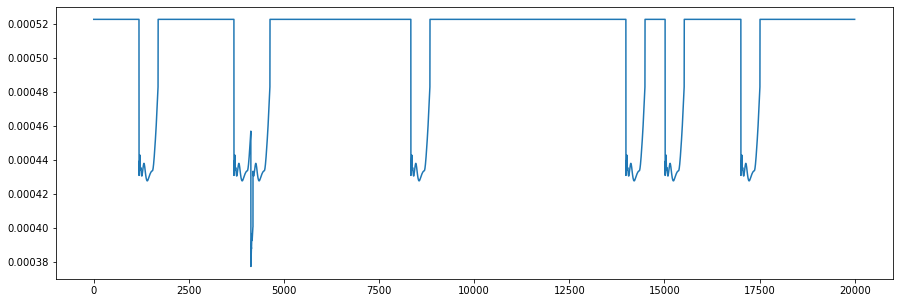

In [13]:
plt.figure(figsize = (15,5))
plt.plot(P_test[0].cpu().detach().numpy()[:])
#plt.scatter(np.arange(20000), S_test[0][12000:32000].cpu().detach().numpy(), s=1, color="black")
#plt.scatter(np.arange(20000), test_S_out[0][:].cpu().detach().numpy()*0.9, s=1, color="red")
print(torch.max(P_test))
print(model.W_refract)